<a href="https://colab.research.google.com/github/chandika2006/market/blob/main/Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd

# Collecting Apple's stock data from 2020 to end of 2024
df = yf.download('AAPL', start='2020-01-01', end='2024-12-31')
data = df[['Close']]  # Focusing on the 'Close' price

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values if any
data = data.dropna()

Price  Ticker
Close  AAPL      0
dtype: int64


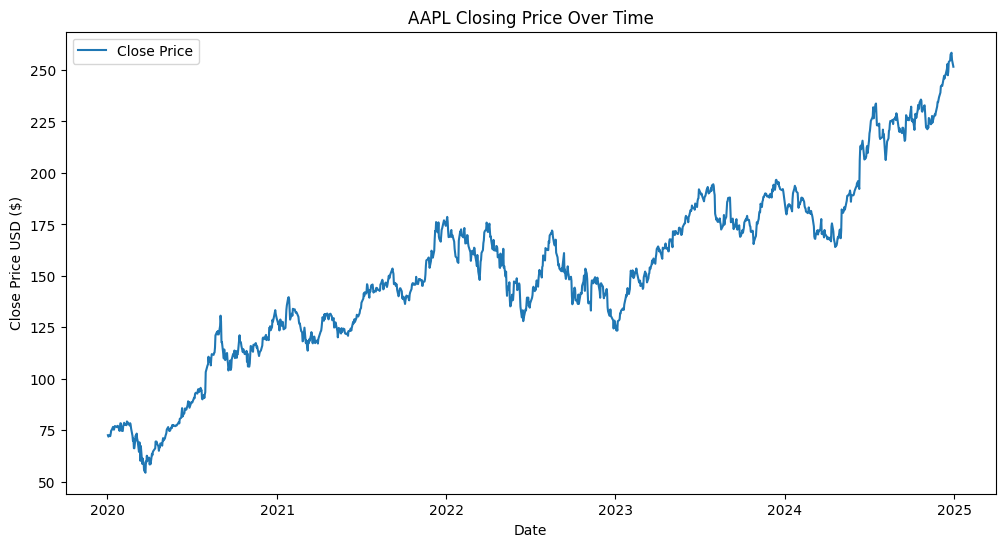

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data, label='Close Price')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Train-test split (80-20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Sequence generator function
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0543
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0023
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0012
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.3403e-04
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 7.3421e-04
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 7.3826e-04
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 8.7535e-04
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 7.4546e-04
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 6.8386e-04
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.5440e-04


In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Optional: Calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Root Mean Squared Error (RMSE): 7.2901507378954165


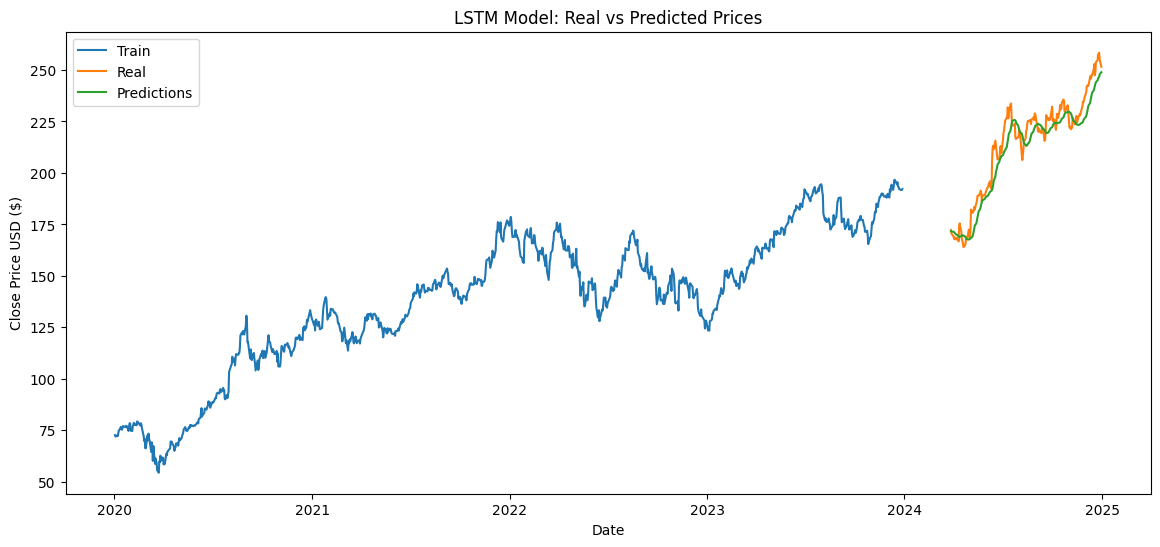

In [ ]:
# Prepare valid data for plotting
valid = data[train_size:].copy()
valid = valid.iloc[60:].copy()  # adjust for sequence shift
valid['Predictions'] = predictions

plt.figure(figsize=(14, 6))
plt.title('LSTM Model: Real vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data[:train_size], label='Train')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Real', 'Predictions'])
plt.show()